In [159]:
using SparseArrays
using LinearAlgebra
using LinearAlgebra.LAPACK
using Arpack
using Plots

In [2]:
function Lp(L)
    return sparse(1:2*L, 2:2*L+1, ones(Float64, 2*L), 2*L+1, 2*L+1) 
end

function Lm(L)
    return sparse(2:2*L+1, 1:2*L, ones(Float64, 2*L), 2*L+1, 2*L+1)
end

function LzLz(L)
    return sparse(1:2*L+1, 1:2*L+1, map(x -> convert(Float64, x^2), -L:L))
end

LzLz (generic function with 1 method)

In [107]:
print(Lp(2))
print(Lm(2))
print(LzLz(2))


  ⋅   1.0   ⋅    ⋅    ⋅ 
  ⋅    ⋅   1.0   ⋅    ⋅ 
  ⋅    ⋅    ⋅   1.0   ⋅ 
  ⋅    ⋅    ⋅    ⋅   1.0
  ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅ 
 1.0   ⋅    ⋅    ⋅    ⋅ 
  ⋅   1.0   ⋅    ⋅    ⋅ 
  ⋅    ⋅   1.0   ⋅    ⋅ 
  ⋅    ⋅    ⋅   1.0   ⋅ 
 4.0   ⋅    ⋅    ⋅    ⋅ 
  ⋅   1.0   ⋅    ⋅    ⋅ 
  ⋅    ⋅   0.0   ⋅    ⋅ 
  ⋅    ⋅    ⋅   1.0   ⋅ 
  ⋅    ⋅    ⋅    ⋅   4.0

In [4]:
function insert(matList, idxList, Nsites)
    count = 1;
    res = sparse([1], [1], [1.0]);
    dim = size(matList[1])[1];
    for i in 1:Nsites
        if i in idxList
            res = kron(res, matList[count]);
            count += 1;
        else 
            res = kron(res, sparse(I, dim, dim));
        end
    end
    return res
end

insert (generic function with 1 method)

In [262]:
function HSG(b, h, L, Nsites)
    return ((1/2)*sum(map(idx -> insert([LzLz(L)], [idx], Nsites), 1:Nsites))
              -(h/2)*sum(map(idx -> insert([Lp(L)+Lm(L)], [idx], Nsites), 1:Nsites))
              - (b/2)*sum(map(idx -> insert([Lp(L), Lm(L)], [idx, idx+1], Nsites), 1:Nsites-1))
              - (b/2)*sum(map(idx -> insert([Lm(L), Lp(L)], [idx, idx+1], Nsites), 1:Nsites-1)));
end

HSG (generic function with 1 method)

In [6]:
evals, evecs = eigs(LzLz(10)+100*Lp(10)+100*Lm(10), nev = 20, which=:SR)

([-190.0623873117172, -170.30637876169715, -150.74187942846618, -131.1544191565216, -111.05073685944551, -89.75896908411501, -66.76404978372675, -41.94792195778896, -15.55540448059311, 11.956887666009132, 40.03436099736714, 68.0813287563095, 95.48603485603468, 121.63007251193912, 145.88280108954544, 167.6116576440951, 185.30176084101052, 203.2864190105219, 206.85295164801184, 245.60132337124776], [-0.002461954489837298 0.010124193847264651 … -0.1809075617402664 0.2663032056698048; 0.007141203967749507 -0.02736634176735514 … -0.19330506947392445 0.38774099163529097; … ; 0.007141203967749532 0.027366341767355112 … -0.19330506947393133 -0.3877409916388189; -0.002461954489837437 -0.010124193847264172 … -0.18090756174027364 -0.2663032056722274], 20, 1, 21, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

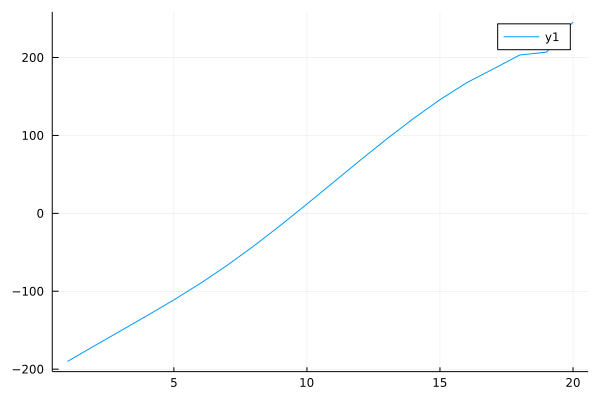

In [7]:
plot(1:20, evals[1:20])

In [8]:
function cosX(x, state, L, Nsites)
    return state'*insert([Lp(L)+Lm(L)], [x], Nsites)*state/2.0;
end

function sinX(x, state, L, Nsites)
    return real(state'*insert([Lp(L)-Lm(L)], [x], Nsites)*state/(2.0im));
end

sinX (generic function with 1 method)

In [277]:
Nsites = 7;
targSt = 100; 
L=3; 
evals, evecs = eigs(HSG(1, 1, L, Nsites), nev = targSt+1, which=:SR);

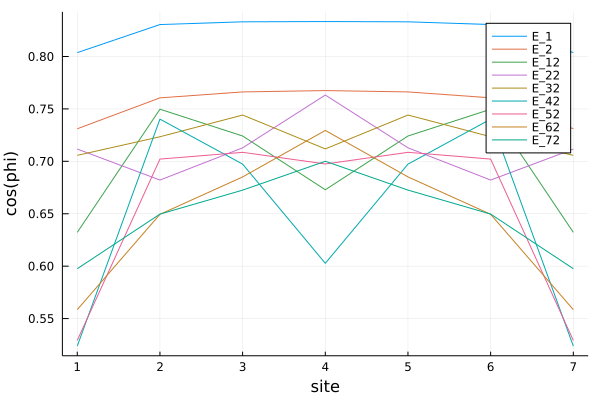

In [278]:
p = plot(1:Nsites, [cosX(x, normalize(evecs[:, 1]), L, Nsites) for x in 1:Nsites], label = "E_1")
for i in 2:10:80
    plot!(1:Nsites, [cosX(x, normalize(evecs[:, i]), L, Nsites) for x in 1:Nsites], xlabel = "site", ylabel="cos(phi)", label = "E_"*string(i))
end
p

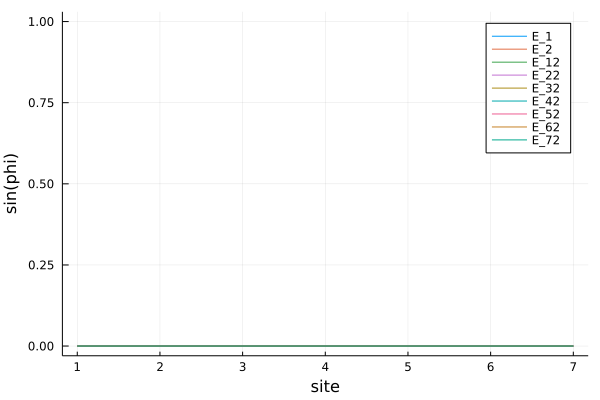

In [11]:
p = plot(1:Nsites, [sinX(x, normalize(evecs[:, 1]), L, Nsites) for x in 1:Nsites], label="E_1")
for i in 2:10:80
    plot!(1:Nsites, [sinX(x, normalize(evecs[:, i]), L, Nsites) for x in 1:Nsites], xlabel = "site", ylabel="sin(phi)", label = "E_"*string(i))
end
p

In [275]:
function Mag(state, L, Nsites)
    return state'*reduce(+, [insert([Lp(L)+Lm(L)], [x], Nsites) for x in 1:Nsites])*state/(2.0*Nsites);
end

Mag (generic function with 1 method)

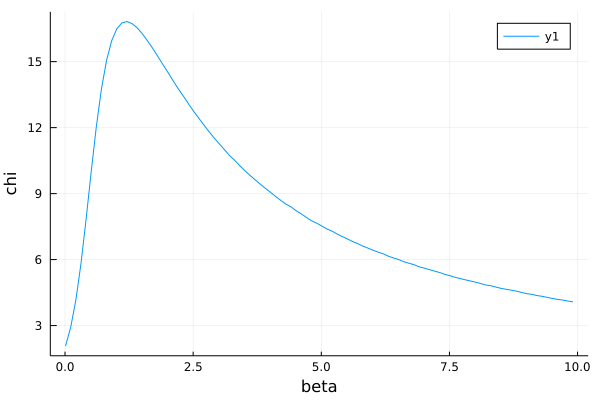

In [271]:
Nsites = 6;
targSt = 1; 
L=1; 
h = 4e-5;
delh = 1e-12;
chiList = Vector{Float64}();
for b in 0.01:0.1:10.0
    evals, evecs = eigs(HSG(b, h+delh, L, Nsites), nev = targSt, which=:SR);
    Mp = Mag(evecs[:, 1], L, Nsites);
    evals, evecs = eigs(HSG(b, h-delh, L, Nsites), nev = targSt, which=:SR);
    Mm = Mag(evecs[:, 1], L, Nsites);
    append!(chiList, abs(Mp-Mm)/(2*delh));
end
plot(0.01:0.1:10.0, chiList, xlabel = "beta", ylabel="chi")

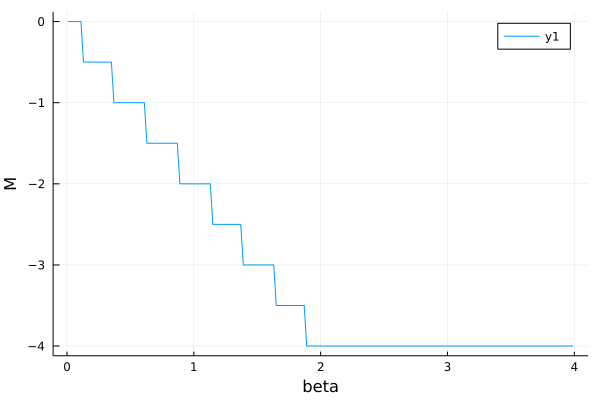

In [268]:
Nsites = 8;
targSt = 1; 
L=1; 
h = 0;
MList = Vector{Float64}();
for b in 0.01:0.02:4.0
    H = ((b/2)*sum(map(idx -> insert([sparse(1:2*L+1, 1:2*L+1, -L:L)], [idx], Nsites), 1:Nsites))
              - (1/2)*sum(map(idx -> insert([Lp(L), Lm(L)], [idx, idx+1], Nsites), 1:Nsites-1))
              - (1/2)*sum(map(idx -> insert([Lm(L), Lp(L)], [idx, idx+1], Nsites), 1:Nsites-1)))
    evals, evecs = eigs(H, nev = targSt, which=:SR);
    M = evecs[:, targSt]'*sum(map(idx -> insert([sparse(1:2*L+1, 1:2*L+1, -L:L)], [idx], Nsites), 1:Nsites))*evecs[:, targSt]/2.0;
    append!(MList, M);
end
plot(0.01:0.02:4.0, MList, xlabel = "beta", ylabel="M")

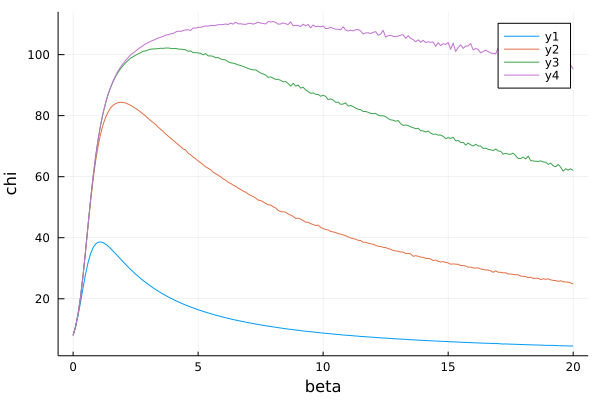

In [269]:
Nsites = 4;
targSt = 1; 
h = 4e-5;
delh = 1e-12;
p = plot()
for L in 1:4
    chiList = Vector{Float64}();
    for b in 0.0:0.1:20.0
        evals, evecs = eigs(HSG(b, h+delh, L, Nsites), nev = targSt, which=:SR);
        Mp = Mag(evecs[:, 1], L, Nsites);
        evals, evecs = eigs(HSG(b, h-delh, L, Nsites), nev = targSt, which=:SR);
        Mm = Mag(evecs[:, 1], L, Nsites);
        append!(chiList, abs(Mp-Mm)/(2*delh));
    end
    p = plot!(0.0:0.1:20.0, chiList, xlabel = "beta", ylabel="chi")
end
p

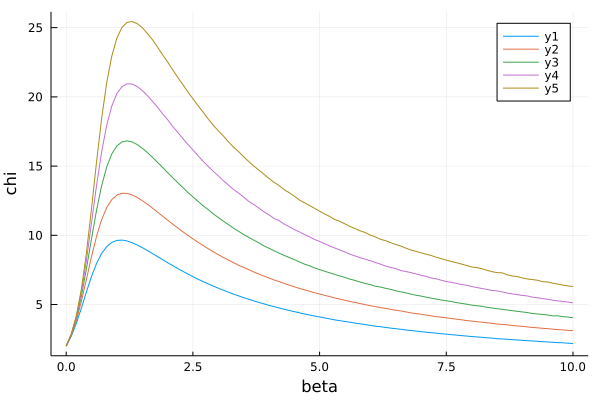

In [276]:
targSt = 1; 
L=1; 
h = 4e-5;
delh = 1e-12;
p = plot()
for Nsites in 4:8
    chiList = Vector{Float64}();
    for b in 0.0:0.1:10.0
        evals, evecs = eigs(HSG(b, h+delh, L, Nsites), nev = targSt, which=:SR);
        Mp = Mag(evecs[:, 1], L, Nsites);
        evals, evecs = eigs(HSG(b, h-delh, L, Nsites), nev = targSt, which=:SR);
        Mm = Mag(evecs[:, 1], L, Nsites);
        append!(chiList, abs(Mp-Mm)/(2*delh));
    end
    p = plot!(0.0:0.1:10.0, chiList, xlabel = "beta", ylabel="chi")
end
p

In [16]:
Nsites = 7;
targSt = 301; 
L=1; 
anim = @animate for b in 0.1:0.1:2
    evals, evecs = eigs(HSG(b, 1, L, Nsites), nev = targSt, which=:SR);
    plot(1:Nsites, [cosX(x, normalize(evecs[:, targSt]), L, Nsites) for x in 1:Nsites], label = "E_"*string(targSt), ylims = (0,1), title="b="*string(b))
end

Animation("C:\\Users\\kwibu\\AppData\\Local\\Temp\\jl_QbylSU", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png", "000011.png", "000012.png", "000013.png", "000014.png", "000015.png", "000016.png", "000017.png", "000018.png", "000019.png", "000020.png"])

┌ Info: Saved animation to 
│   fn = C:\Users\kwibu\workspace\quantum_link\QuLAT\Hiroki\jupyter_notebooks\julia\sin.gif
└ @ Plots C:\Users\kwibu\.julia\packages\Plots\S2aH5\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\kwibu\\workspace\\quantum_link\\QuLAT\\Hiroki\\jupyter_notebooks\\julia\\sin.gif")
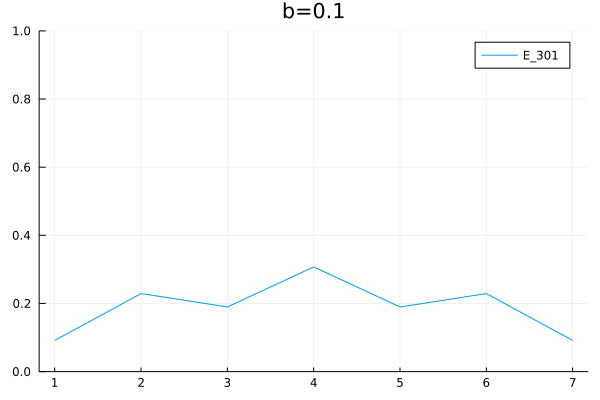

In [17]:
gif(anim, "sin.gif", fps=10)

In [97]:
function baseChange(dec, base, Ndeg)
    # LSB is in the RHS 
    if dec == 0
        count = -1
    else 
        count = floor(Int64, log(base, dec));
    end 
    
    str = "0"^(Ndeg - count - 1)
    while count >= 0
        d = dec ÷ (base^count);
        str *= string(d)
        dec -= d*(base^count); 
        count -= 1;
    end
    
    return str
end

function baseBackto10(str, base)
    # LSB is in the RHS 
    count = 0;
    res = 0;
    for s in reverse(str)
        res += parse(Int64, s)*(base^count);
        count += 1;
    end
    return res
end

baseBackto10 (generic function with 1 method)

In [314]:
function partialTr(rho, siteList, sd, Nsites)
    rhorows = rowvals(rho)
    rhovals = nonzeros(rho)
    trRho = spzeros(sd^(Nsites-size(siteList)[1]), sd^(Nsites-size(siteList)[1]))

    for col in 1:sd^Nsites
        colfluxBasis = baseChange(col-1, sd, Nsites);
        l = reduce(*, [colfluxBasis[m] for m in 1:Nsites if m ∉ siteList]);
        ll = reduce(*, [colfluxBasis[m] for m in 1:Nsites if m in siteList]);

        for i in nzrange(rho, col)
            row = rhorows[i];
            rowfluxBasis = baseChange(row-1, sd, Nsites);
            k = reduce(*, [rowfluxBasis[m] for m in 1:Nsites if m ∉ siteList]);
            kk = reduce(*, [rowfluxBasis[m] for m in 1:Nsites if m in siteList]);

            if kk == ll
                trRho[baseBackto10(k, sd)+1, baseBackto10(l, sd)+1] += rhovals[i]
            end
        end
    end
    return trRho
end


partialTr (generic function with 1 method)

In [242]:
function vNentropy(rho)
    evals, evecL, evecR = LAPACK.geev!('N', 'N', Matrix(rho))
    return -reduce(+, [ev*log(ev) for ev in evals if ev > 0])
end

vNentropy (generic function with 1 method)

In [315]:
vNentropy(partialTr(sparse([1], [1], [1.0], 9, 1)*sparse([1], [1], [1.0], 9, 1)', [1], 3, 2))

-0.0

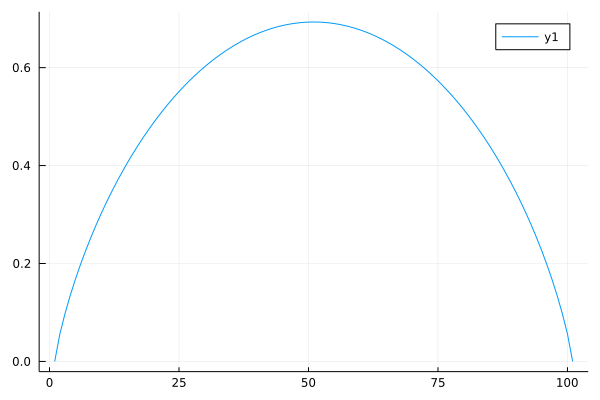

In [316]:
plot([vNentropy(partialTr(sparse([1, 9], [1, 1], [sqrt(t), sqrt(1-t)], 9, 1)*sparse([1, 9], [1, 1], [sqrt(t), sqrt(1-t)], 9, 1)', [1], 3, 2)) for t in 0.0:0.01:1.0])

In [350]:
Nsites = 4;
targSt = 1; 
L=1; 
h = 1;
eeList = Vector{Float64}();
for b in 0.001:0.01:1.0
    evals, evecs = eigs(HSG(b, h, L, Nsites), nev = targSt, which=:SR);
    append!(eeList, vNentropy(partialTr(sparse(evecs[:, 1]*evecs[:, 1]'), [1, 2, 3, 4], 2*L+1, Nsites)));
end

In [329]:
eeList2 = Vector{Float64}();
for h in 0.001:0.01:1.0
    evals, evecs = eigs(HSG(b, h, L, Nsites), nev = targSt, which=:SR);
    append!(eeList2, vNentropy(partialTr(sparse(evecs[:, 1]*evecs[:, 1]'), [2,3, 4], 2*L+1, Nsites)));
end

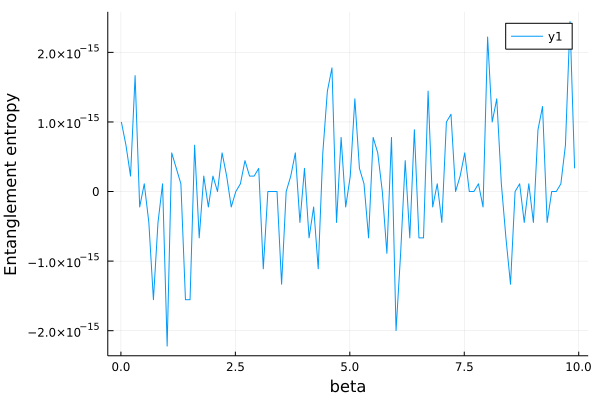

In [351]:
plot(0.01:0.1:10.0, eeList, xlabel = "beta", ylabel="Entanglement entropy")
#plot!(0.01:0.1:10.0, eeList2, xlabel = "beta", ylabel="Entanglement entropy")

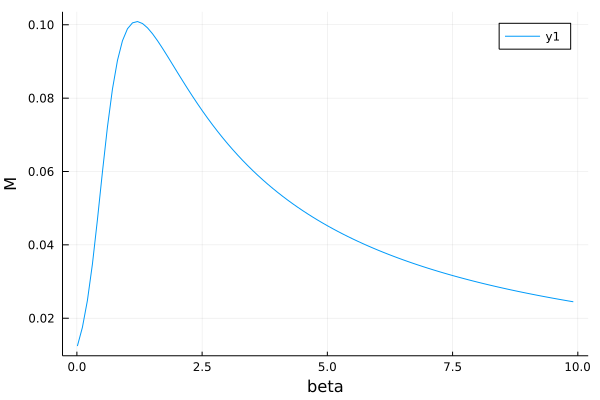

In [199]:
MList = Vector{Float64}();
for b in 0.01:0.1:10.0
    evals, evecs = eigs(HSG(b, h, L, Nsites), nev = targSt, which=:SR);
    append!(MList, Mag(evecs[:, 1], L, Nsites););
end
plot(0.01:0.1:10.0, MList, xlabel = "beta", ylabel="M")

0.07630826564491458


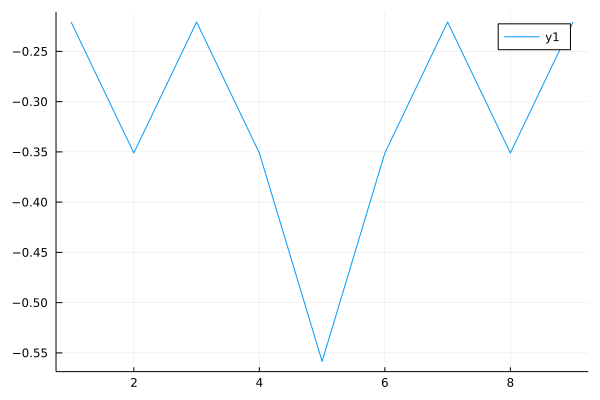

In [247]:
evals, evecs = eigs(HSG(0, 3, L, 2), nev = targSt, which=:SR);
print(vNentropy(partialTr(sparse(evecs[:, 1]*evecs[:, 1]'), [1], 2*L+1, 2)))
print("\n")
plot(evecs[:, 1])